In [45]:
import numpy as np
from scipy.special import gamma

def run_aquila(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_aquilas = len(positions)
    dim = positions.shape[1]
    alpha = 0.1
    delta = 0.1
    beta = 1.5
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    for i in range(num_aquilas):
        current_fitness = np.linalg.norm(positions[i] - prey_pos)
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            X_best = positions[i].copy()
    for iter in range(max_iter):
        X_M = np.mean(positions, axis=0)
        for i in range(num_aquilas):
            if iter <= (2/3)*max_iter:
                if np.random.rand() < 0.5:
                    positions[i] = X_best * (1 - iter/max_iter) + (X_M - X_best) * np.random.rand()
                else:
                    r = np.random.rand()
                    theta = np.random.rand() * 2 * np.pi
                    x = r * np.sin(theta)
                    y = r * np.cos(theta)
                    sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) /(gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
                    u = np.random.randn(dim) * sigma
                    v = np.random.randn(dim)
                    levy = 0.01 * u / np.abs(v)**(1/beta)
                    positions[i] = X_best * levy + positions[np.random.randint(num_aquilas)] + (y - x) * np.random.rand()
            else:
                if np.random.rand() < 0.5:
                    positions[i] = (X_best * X_M) * alpha - np.random.rand() + ((ub - lb) * np.random.rand() + lb) * delta
                else:
                    QF = iter**((2*np.random.rand()-1)/(1 - max_iter)**2)
                    G1 = 2 * np.random.rand() - 1
                    G2 = 2 * (1 - iter/max_iter)
                    levy = np.random.rand()
                    positions[i] = QF * X_best - G1 * positions[i] * np.random.rand() - G2 * levy + np.random.rand()
            positions[i] = np.clip(positions[i], lb, ub)
            current_fitness = np.linalg.norm(positions[i] - prey_pos)
            if current_fitness < best_fitness:
                best_fitness = current_fitness
                X_best = positions[i].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [46]:
import numpy as np

def run_modified(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_aquilas = len(positions)
    dim = positions.shape[1]
    alpha = 0.1
    delta = 0.1
    beta = 1.8
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    for i in range(num_aquilas):
        current_fitness = np.linalg.norm(positions[i] - prey_pos)
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            X_best = positions[i].copy()
    def reflective_boundaries(position, lb, ub):
        position = np.where(position < lb, 2 * lb - position, position)
        position = np.where(position > ub, 2 * ub - position, position)
        return position
    for iter in range(max_iter):
        fitness_values = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
        weights = 1 / (fitness_values + np.finfo(float).eps)
        weighted_mean = np.sum(positions * weights[:, np.newaxis], axis=0) / np.sum(weights)
        for i in range(num_aquilas):
            if iter <= (2/3)*max_iter:
                if np.random.rand() < 0.5:
                    positions[i] = X_best * (1 - iter/max_iter) + (weighted_mean - X_best) * np.random.rand()
                else:
                    r = np.random.rand()
                    theta = np.random.rand() * 2 * np.pi
                    x = r * np.sin(theta)
                    y = r * np.cos(theta)
                    sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) /(gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
                    u = np.random.randn(dim) * sigma
                    v = np.random.randn(dim)
                    levy = 0.01 * u / np.abs(v)**(1/beta)
                    positions[i] = X_best * levy + positions[np.random.randint(num_aquilas)] + (y - x) * np.random.rand()
            else:
                if np.random.rand() < 0.5:
                    positions[i] = (X_best * weighted_mean) * alpha - np.random.rand() + ((ub - lb) * np.random.rand() + lb) * delta
                else:
                    QF = iter**((2*np.random.rand()-1)/(1 - max_iter)**2)
                    G1 = 2 * np.random.rand() - 1
                    G2 = 2 * (1 - iter/max_iter)
                    levy = np.random.rand()
                    positions[i] = QF * X_best - G1 * positions[i] * np.random.rand() - G2 * levy + np.random.rand()
            positions[i] = reflective_boundaries(positions[i], lb, ub)
            current_fitness = np.linalg.norm(positions[i] - prey_pos)
            if current_fitness < best_fitness:
                best_fitness = current_fitness
                X_best = positions[i].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [38]:
import numpy as np
from scipy.stats import levy

def run_rao(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_predators = len(positions)
    dim = positions.shape[1]
    FADs = 0.2
    P = 0.5
    restart_interval = 100
    def tent_map(n, x0=0.7):
        x = np.zeros(n)
        x[0] = x0
        for i in range(n - 1):
            if x[i] < 0.5:
                x[i+1] = 2 * x[i]
            else:
                x[i+1] = 2 * (1 - x[i])
            x[i+1] = (1 - 1e-6) * x[i+1] + 1e-6 * np.random.rand()
        return x
    def opposition_based_learning(population, fitness, lb, ub):
        new_population = np.zeros_like(population)
        for i in range(len(population)):
            opposition = lb + ub - population[i]
            opposition = np.clip(opposition, lb, ub)
            opposition_fitness = np.linalg.norm(opposition - prey_pos)
            if opposition_fitness < fitness[i]:
                new_population[i] = opposition
            else:
                new_population[i] = population[i]
        return new_population
    initial_positions = np.zeros((num_predators, dim))
    for d in range(dim):
        chaos_sequence = tent_map(num_predators, np.random.rand())
        initial_positions[:, d] = lb + (ub - lb) * chaos_sequence
    positions = initial_positions.copy()
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
    best_index = np.argmin(fitness)
    X_best = positions[best_index].copy()
    best_fitness = fitness[best_index]
    for iter in range(max_iter):
        if iter % restart_interval == 0 and iter > 0:
            for i in range(num_predators):
                positions[i] = lb + np.random.rand(dim) * (ub - lb)
            fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
            best_index = np.argmin(fitness)
            X_best = positions[best_index].copy()
            best_fitness = fitness[best_index]
        sorted_indices = np.argsort(fitness)
        sorted_positions = positions[sorted_indices]
        CF = (1 - iter / max_iter)**(2 * iter / max_iter)
        t = iter + 1
        T = max_iter
        for i in range(num_predators):
            if iter < max_iter / 3:
                step_size = np.random.rand(dim) * (sorted_positions[i] - prey_pos) * CF
                positions[i] = positions[i] + step_size
            elif iter < 2 * max_iter / 3:
                if np.random.rand() < P:
                    step_size = np.random.randn(dim) * (sorted_positions[i] - prey_pos)
                    positions[i] = positions[i] + step_size
                else:
                    step_size = levy.rvs(1.5, size=dim) * (sorted_positions[i] - prey_pos) * CF
                    positions[i] = positions[i] + step_size
            else:
                phi = 2 * np.random.rand(dim) - 1
                decay_factor = (1 - t / T)**(2 * t / T)
                if np.random.rand() < 0.5:
                    positions[i] = X_best + decay_factor * (X_best - positions[i]) * phi
                else:
                    LF = levy.rvs(1.5, size=dim)
                    positions[i] = X_best + LF * (X_best - positions[i]) * np.random.rand(dim)
            if np.random.rand() < 0.2:
                chaos_dim = np.random.randint(dim)
                chaos_sequence = tent_map(5, np.random.rand())
                for chaos_val in chaos_sequence:
                    perturbed_value = X_best[chaos_dim] + (ub - lb) * chaos_val * 0.1
                    perturbed_position = positions[i].copy()
                    perturbed_position[chaos_dim] = np.clip(perturbed_value, lb, ub)
                    perturbed_fitness = np.linalg.norm(perturbed_position - prey_pos)
                    if perturbed_fitness < fitness[i]:
                        positions[i] = perturbed_position
                        fitness[i] = perturbed_fitness
                        if perturbed_fitness < best_fitness:
                            best_fitness = perturbed_fitness
                            X_best = perturbed_position.copy()
                        break
            positions[i] = np.clip(positions[i], lb, ub)
        positions = opposition_based_learning(positions, fitness, lb, ub)
        fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
        best_index = np.argmin(fitness)
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            X_best = positions[best_index].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [39]:
import numpy as np
from scipy.stats import levy

def run_ehaompa(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_predators = len(positions)
    dim = positions.shape[1]
    FADs = 0.2
    P = 0.5
    def random_opposition(position, lb, ub):
        dim = len(position)
        opposition = np.zeros_like(position)
        for i in range(dim):
            rand = np.random.rand()
            opposition[i] = lb + ub - position[i] + rand * (position[i] - (lb + ub) / 2)
        return np.clip(opposition, lb, ub)
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
    best_index = np.argmin(fitness)
    X_best = positions[best_index].copy()
    best_fitness = fitness[best_index]
    for iter in range(max_iter):
        sorted_indices = np.argsort(fitness)
        sorted_positions = positions[sorted_indices]
        CF = (1 - iter / max_iter)**(2 * iter / max_iter)
        for i in range(num_predators):
            if iter < max_iter / 3:
                step_size = np.random.rand(dim) * (sorted_positions[i] - prey_pos) * CF
                positions[i] = positions[i] + step_size
            elif iter < 2 * max_iter / 3:
                if np.random.rand() < P:
                    step_size = np.random.randn(dim) * (sorted_positions[i] - prey_pos)
                    positions[i] = positions[i] + step_size
                else:
                    step_size = levy.rvs(1.5, size=dim) * (sorted_positions[i] - prey_pos) * CF
                    positions[i] = positions[i] + step_size
            else:
                step_size = np.random.rand(dim) * (X_best - positions[i]) * CF
                positions[i] = positions[i] + step_size + FADs * (np.random.rand(dim) - 0.5) * CF
            positions[i] = np.clip(positions[i], lb, ub)
            if np.random.rand() < 0.1:
                opposition = random_opposition(positions[i], lb, ub)
                opposition_fitness = np.linalg.norm(opposition - prey_pos)
                if opposition_fitness < fitness[i]:
                    positions[i] = opposition
                    fitness[i] = opposition_fitness
                    if opposition_fitness < best_fitness:
                        best_fitness = opposition_fitness
                        X_best = opposition.copy()
        fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
        current_best_index = np.argmin(fitness)
        if fitness[current_best_index] < best_fitness:
            best_fitness = fitness[current_best_index]
            X_best = positions[current_best_index].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [40]:
import numpy as np
from scipy.stats import levy

def run_teao(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_predators = len(positions)
    dim = positions.shape[1]
    FADs = 0.2
    P = 0.5
    def tent_map(n, x0=0.7):
        x = np.zeros(n)
        x[0] = x0
        for i in range(n - 1):
            if x[i] < 0.5:
                x[i+1] = 2 * x[i]
            else:
                x[i+1] = 2 * (1 - x[i])
            x[i+1] = (1 - 1e-6) * x[i+1] + 1e-6 * np.random.rand()
        return x
    def random_opposition(position, lb, ub):
        dim = len(position)
        opposition = np.zeros_like(position)
        for i in range(dim):
            rand = np.random.rand()
            opposition[i] = lb + ub - position[i] + rand * (position[i] - (lb + ub) / 2)
        return np.clip(opposition, lb, ub)
    initial_positions = np.zeros((num_predators, dim))
    for d in range(dim):
        chaos_sequence = tent_map(num_predators, np.random.rand())
        initial_positions[:, d] = lb + (ub - lb) * chaos_sequence
    positions = initial_positions.copy()
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
    best_index = np.argmin(fitness)
    X_best = positions[best_index].copy()
    best_fitness = fitness[best_index]
    for iter in range(max_iter):
        sorted_indices = np.argsort(fitness)
        sorted_positions = positions[sorted_indices]
        CF = (1 - iter / max_iter)**(2 * iter / max_iter)
        t = iter + 1
        T = max_iter
        for i in range(num_predators):
            if iter < max_iter / 3:
                step_size = np.random.rand(dim) * (sorted_positions[i] - prey_pos) * CF
                positions[i] = positions[i] + step_size
            elif iter < 2 * max_iter / 3:
                if np.random.rand() < P:
                    step_size = np.random.randn(dim) * (sorted_positions[i] - prey_pos)
                    positions[i] = positions[i] + step_size
                else:
                    step_size = levy.rvs(1.5, size=dim) * (sorted_positions[i] - prey_pos) * CF
                    positions[i] = positions[i] + step_size
            else:
                phi = 2 * np.random.rand(dim) - 1
                decay_factor = (1 - t / T)**(2 * t / T)
                if np.random.rand() < 0.5:
                    positions[i] = X_best + decay_factor * (X_best - positions[i]) * phi
                else:
                    LF = levy.rvs(1.5, size=dim)
                    positions[i] = X_best + LF * (X_best - positions[i]) * np.random.rand(dim)
            positions[i] = np.clip(positions[i], lb, ub)
            if np.random.rand() < 0.1:
                opposition = random_opposition(positions[i], lb, ub)
                opposition_fitness = np.linalg.norm(opposition - prey_pos)
                if opposition_fitness < fitness[i]:
                    positions[i] = opposition
                    fitness[i] = opposition_fitness
                    if opposition_fitness < best_fitness:
                        best_fitness = opposition_fitness
                        X_best = opposition.copy()
        fitness = np.array([np.linalg.norm(pos - prey_pos) for pos in positions])
        current_best_index = np.argmin(fitness)
        if fitness[current_best_index] < best_fitness:
            best_fitness = fitness[current_best_index]
            X_best = positions[current_best_index].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [47]:
import numpy as np
import math
from scipy.stats import t

def run_iao(prey_pos, positions, max_iter=500, lb=0, ub=100):
    num_aquilas = len(positions)
    dim = positions.shape[1]
    alpha = 0.1
    delta = 0.1
    beta = 1.5
    def tent_map(n, x0=0.7):
        x = np.zeros(n)
        x[0] = x0
        for i in range(n - 1):
            if x[i] < 0.5:
                x[i+1] = 2 * x[i]
            else:
                x[i+1] = 2 * (1 - x[i])
            x[i+1] = (1 - 1e-6) * x[i+1] + 1e-6 * np.random.rand()
        return x
    initial_positions = np.zeros((num_aquilas, dim))
    for d in range(dim):
        chaos_sequence = tent_map(num_aquilas, np.random.rand())
        initial_positions[:, d] = lb + (ub - lb) * chaos_sequence
    positions = initial_positions.copy()
    X_best = positions[0].copy()
    best_fitness = float('inf')
    convergence_curve = np.zeros(max_iter)
    for i in range(num_aquilas):
        current_fitness = np.linalg.norm(positions[i] - prey_pos)
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            X_best = positions[i].copy()
    for iter in range(max_iter):
        df = 5 + 95 * (iter / max_iter)
        X_M = np.mean(positions, axis=0)
        for i in range(num_aquilas):
            if iter <= (2/3)*max_iter:
                if np.random.rand() < 0.5:
                    positions[i] = X_best * (1 - iter/max_iter) + (X_M - X_best) * t.rvs(df, size=dim)
                else:
                    r = np.random.rand()
                    theta = np.random.rand() * 2 * np.pi
                    x = r * np.sin(theta)
                    y = r * np.cos(theta)
                    sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) /(gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
                    u = t.rvs(df, size=dim) * sigma
                    v = t.rvs(df, size=dim)
                    levy = 0.01 * u / np.abs(v)**(1/beta)
                    positions[i] = X_best * levy + positions[np.random.randint(num_aquilas)] + (y - x) * np.random.rand()
            else:
                if np.random.rand() < 0.5:
                    positions[i] = (X_best - X_M) * alpha - np.random.rand() + ((ub - lb) * np.random.rand() + lb) * delta
                else:
                    QF = iter**((2*np.random.rand()-1)/(1 - max_iter)**2)
                    G1 = 2 * np.random.rand() - 1
                    G2 = 2 * (1 - iter/max_iter)
                    levy = np.random.randn(dim) * 0.1
                    positions[i] = QF * X_best - G1 * positions[i] * np.random.rand() - G2 * levy + np.random.rand()
            positions[i] = np.clip(positions[i], lb, ub)
            current_fitness = np.linalg.norm(positions[i] - prey_pos)
            if current_fitness < best_fitness:
                best_fitness = current_fitness
                X_best = positions[i].copy()
        convergence_curve[iter] = best_fitness
    return best_fitness, convergence_curve


In [42]:
from tqdm import tqdm

In [43]:
import pandas as pd

In [63]:

algorithms = {
    'Aquila': run_aquila,
    'Modified': run_modified,
    'RAO': run_rao,
    'EHAOMPA': run_ehaompa,
    'TEAO': run_teao,
    'IAO':run_iao
}

num_runs = 30
num_agents = 30
dim = 2
lb, ub = 0, 100

results = {name: [] for name in algorithms}
convergence_curves = {name: [] for name in algorithms}

for run in tqdm(range(num_runs), desc="Runs"):
    prey_pos = np.random.uniform(lb, ub, size=dim)
    positions = np.random.uniform(lb, ub, size=(num_agents, dim))
    for name, func in algorithms.items():
        best , curve = func(prey_pos.copy(), positions.copy())
        results[name].append(best)
        convergence_curves[name].append(curve)

stats = []
for name, res in results.items():
    stats.append({'Algorithm': name, 'Mean': np.mean(res), 'StdDev': np.std(res, ddof=1)})

df = pd.DataFrame(stats)
df['Rank'] = df['Mean'].rank(method='min')
df = df.sort_values('Mean').reset_index(drop=True)
print(df.to_string(index=False))


Runs: 100%|██████████| 30/30 [02:29<00:00,  4.97s/it]

Algorithm         Mean       StdDev  Rank
     TEAO 8.289665e-16 2.903278e-15   1.0
      IAO 1.838280e-02 1.269570e-02   2.0
 Modified 5.364817e-02 4.273791e-02   3.0
   Aquila 1.204273e-01 2.518829e-01   4.0
  EHAOMPA 1.220708e-01 1.994612e-01   5.0
      RAO 3.587169e-01 1.279416e+00   6.0


In [64]:
df

,Algorithm,Mean,StdDev,Rank
0,TEAO,8.289665e-16,2.903278e-15,1.0
1,IAO,1.838280e-02,1.269570e-02,2.0
2,Modified,5.364817e-02,4.273791e-02,3.0
3,Aquila,1.204273e-01,2.518829e-01,4.0
4,EHAOMPA,1.220708e-01,1.994612e-01,5.0
5,RAO,3.587169e-01,1.279416e+00,6.0


In [71]:
from scipy.stats import wilcoxon
import pandas as pd

baseline = 'Modified'
wilcoxon_results = []

for algo in results:
    if algo == baseline:
        continue
    stat, p = wilcoxon(results[algo], results[baseline])
    wilcoxon_results.append({
        'Algorithm': algo,
        'Baseline': baseline,
        'Statistic': stat,
        'P-value': p
    })

# Convert to DataFrame
df_wilcoxon = pd.DataFrame(wilcoxon_results)

# Save to CSV
df_wilcoxon.to_csv('wilcoxon_results.csv', index=False)

# Optional: print to screen
print(df_wilcoxon)


  Algorithm  Baseline  Statistic       P-value
0    Aquila  Modified      183.0  3.183961e-01
1       RAO  Modified       87.0  2.020182e-03
2   EHAOMPA  Modified      191.0  4.044945e-01
3      TEAO  Modified        0.0  1.862645e-09
4       IAO  Modified       13.0  1.639128e-07


In [66]:
import pandas as pd

# Assuming 'results' is your dictionary of per-run results
stats = []
for name, res in results.items():
    stats.append({'Algorithm': name, 'Mean': np.mean(res), 'StdDev': np.std(res, ddof=1)})
df = pd.DataFrame(stats)
df['Rank'] = df['Mean'].rank(method='min')
df = df.sort_values('Mean').reset_index(drop=True)
print(df.to_string(index=False))


Algorithm         Mean       StdDev  Rank
     TEAO 8.289665e-16 2.903278e-15   1.0
      IAO 1.838280e-02 1.269570e-02   2.0
 Modified 5.364817e-02 4.273791e-02   3.0
   Aquila 1.204273e-01 2.518829e-01   4.0
  EHAOMPA 1.220708e-01 1.994612e-01   5.0
      RAO 3.587169e-01 1.279416e+00   6.0


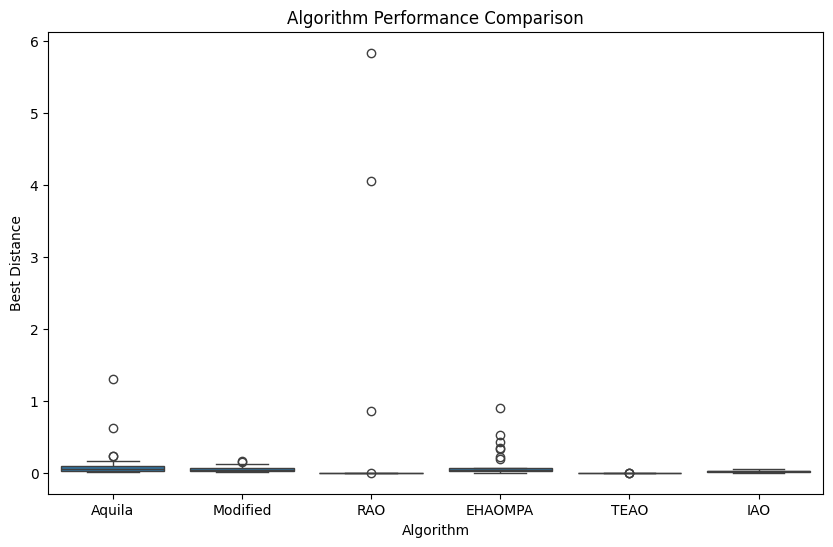

In [67]:
# !pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for seaborn
all_results = []
for algo, vals in results.items():
    for v in vals:
        all_results.append({'Algorithm': algo, 'Distance': v})
df_long = pd.DataFrame(all_results)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Algorithm', y='Distance', data=df_long)
plt.title('Algorithm Performance Comparison')
plt.ylabel('Best Distance')
plt.show()


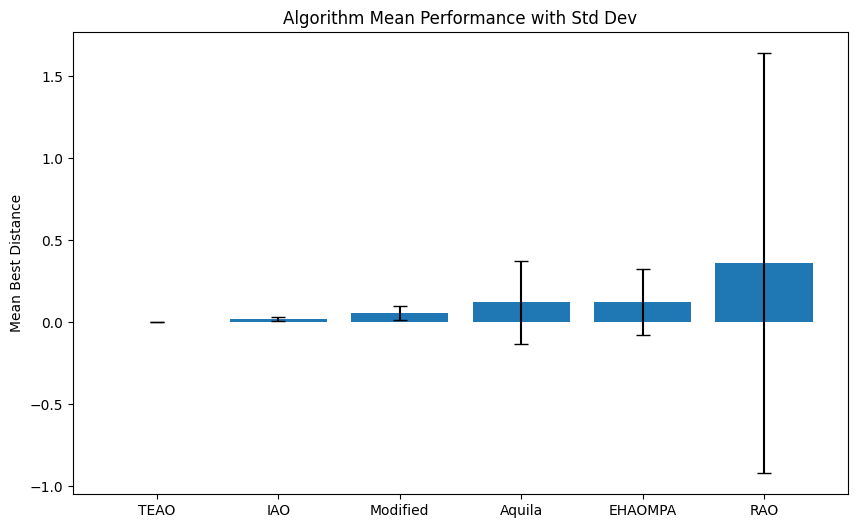

In [68]:
plt.figure(figsize=(10,6))
plt.bar(df['Algorithm'], df['Mean'], yerr=df['StdDev'], capsize=5)
plt.ylabel('Mean Best Distance')
plt.title('Algorithm Mean Performance with Std Dev')
plt.show()


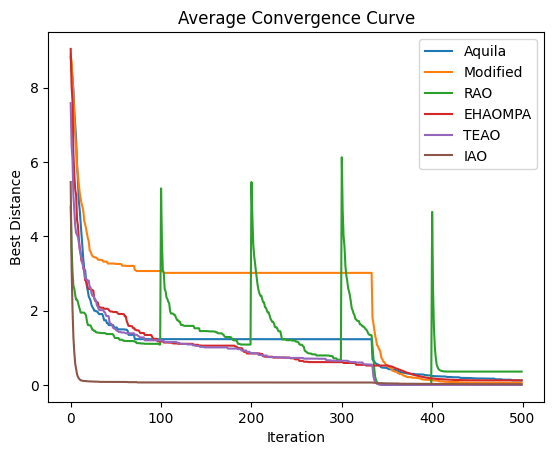

In [69]:
# Suppose you have: convergence_curves[algo] = list of arrays (one per run)
for algo, curves in convergence_curves.items():
    mean_curve = np.mean(curves, axis=0)
    plt.plot(mean_curve, label=algo)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
plt.title('Average Convergence Curve')
plt.legend()
plt.show()


In [70]:
df.to_csv('comparison_list.csv', index=False)
